In [1]:
import numpy as np
import torch
from torch import nn
import os
from tqdm.notebook import tqdm
import pickle
from deepnote import MusicRepr, Constants
from importlib import reload

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

seed_everything(42)

/home/soroosh/projects/general_env/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(
Global seed set to 42


42

## data

In [2]:
const = Constants(unit=4, num_tempo_bins=20, num_velocity_bins=20)
files = pickle.load(open('files.pkl', 'rb'))

data_config = {
#     'data_dir' : '/home/soroosh/data/MIDI/pop909/train/',
#     'data_dir' : '/home/soroosh/data/MIDI/e-gmd-v1.0.0/midis_processed/',
    'data_dir' : '/home/soroosh/data/MIDI/lmd_processed/',
    'files' : files[::-1],
    'const' : const,
    'instruments' : ['piano', 'drums', 'guitar'],
#     'src_instruments' : ['piano', 'drums', 'guitar'],
#     'trg_instruments' : ['piano', 'drums', 'guitar'],
    'max_files' : 10,
    'window_len' : 5,
    'max_len' : 1024,
    'pad_value' : 0,
    'n_jobs' : 20
}

name = 'mix-lmd10-win5-piano-guitar-drums'
print('model name:',name)

model name: mix-lmd10-win5-piano-guitar-drums


In [3]:
import src.data.multi
reload(src.data.multi)

import src.data
reload(src.data)

from src.data import MultiTrackDataset, get_dataloaders

dataset = MultiTrackDataset(**data_config)
n = len(dataset)
n, len(dataset.lens)

  0%|          | 0/10 [00:00<?, ?it/s]

(2920, 10)

In [4]:
sample = dataset[100]
# for k in sample:
#     print(k, len(sample[k]))
for inst in sample:
    print(inst, len(sample[inst]))

piano 340
drums 349
guitar 119


In [5]:
tl, vl = get_dataloaders(dataset, batch_size=2, n_jobs=2)

In [6]:
b = next(iter(vl))
for inst in b:
    print(inst)
    for k in b[inst]:
        print('   ', k, b[inst][k].shape)

piano
    X torch.Size([1, 335])
    X_len torch.Size([1])
    labels torch.Size([1, 335])
drums
    X torch.Size([1, 344])
    X_len torch.Size([1])
    labels torch.Size([1, 344])
guitar
    X torch.Size([1, 116])
    X_len torch.Size([1])
    labels torch.Size([1, 116])


## model

In [7]:
import src.models.mix_enc_dec
reload(src.models.mix_enc_dec)
from src.models.mix_enc_dec import EncoderMixDecoderPerformer

In [8]:
d_model = 256
n_vocab = len(const.all_tokens)
dropout = 0.1
config = {
    'lr' : 1e-4,
    'instruments' : ['piano', 'drums', 'guitar'],
    'embedding': {
        'd_model' : d_model,
        'positional_embedding' : 'relative',
        'n_vocab' : n_vocab,
        'dropout' : dropout,
        'max_len' : 10000
    },
    'encoder' : {
        'd_model' : d_model,
        'n_head' : 8,
        'd_inner' : 512,
        'dropout' : dropout,
        'n_layer' : 4
    },
    'decoder' : {
        'd_model' : d_model,
        'n_head' : 8,
        'd_inner' : 512,
        'dropout' : dropout,
        'n_layer' : 4
    },
    'head' : {
        'd_model' : d_model,
        'n_vocab' : n_vocab
    }
}

model = EncoderMixDecoderPerformer(config)
# model = BasePerformer.load_from_checkpoint(f'weights/{name}/last.ckpt', config=config)
model.count_parameters()

5632029

In [9]:
logits, loss = model('piano', b)
loss

tensor(6.0323, grad_fn=<DivBackward0>)

## train

In [9]:
logger = TensorBoardLogger(save_dir='logs/', name=name)
lr_logger = LearningRateMonitor(logging_interval='step')
checkpoint = ModelCheckpoint(
    dirpath=f'weights/{name}/', 
    filename='{epoch}-{val_loss:.2f}', 
    monitor='train_loss',
    save_top_k=5, 
    period=1
)

trainer = Trainer(
    benchmark=True, 
    gpus=1, 
    accumulate_grad_batches=8,
    logger=logger, 
    max_epochs=30,
    callbacks=[checkpoint, lr_logger]
)

/home/soroosh/projects/general_env/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:396: LightningDeprecationWarning: Argument `period` in `ModelCheckpoint` is deprecated in v1.3 and will be removed in v1.5. Please use `every_n_val_epochs` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [10]:
trainer.fit(model, tl, vl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                  | Params
----------------------------------------------------
0 | criterion | CrossEntropyLoss      | 0     
1 | embedding | RemiEmbedding         | 89.9 K
2 | encoder   | TransformerEncoder    | 2.1 M 
3 | decoder   | TransformerMixDecoder | 3.2 M 
4 | heads     | ModuleDict            | 270 K 
----------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.528    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/soroosh/projects/general_env/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/soroosh/projects/general_env/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/soroosh/projects/MMG/src/data/multi.py", line 92, in fn
    M = max(x_len)
ValueError: max() arg is an empty sequence


In [14]:
trainer.save_checkpoint(f'weights/{name}/last.ckpt')

## generate

In [21]:
import src.modules.mix_decoder
reload(src.modules.mix_decoder)

import src.modules
reload(src.modules)

import src.models.mix_enc_dec
reload(src.models.mix_enc_dec)
from src.models.mix_enc_dec import EncoderMixDecoderPerformer

gen_model = EncoderMixDecoderPerformer.load_from_checkpoint(f"weights/{name}/last.ckpt", config=config)

In [33]:
import random

path = data_config['data_dir']
files = os.listdir(path)
idx = random.randint(0, len(files))
file = files[idx]
print('idx:', idx, ' file:', file)
seq = MusicRepr.from_file(path + file, const=const).keep_instruments(['piano','drums', 'guitar'])
seq.get_instruments()

idx: 819  file: b9d553cb8d186b97b1a250cfc2838831.mid


['guitar', 'drums', 'piano']

In [58]:
trg_inst = 'guitar'
prompt = MusicRepr.concatenate(seq.get_bars()[30:50]).remove_instruments([trg_inst])
prompt.get_instruments(), len(prompt), len(prompt.to_remi())

(['drums', 'piano'], 1187, 3822)

In [65]:
res = gen_model.generate(trg_inst, seq=prompt, window=10, top_p=1., t=1.)
print(len(res))

gen_seq = MusicRepr.from_indices(res, const=const)
len(gen_seq)

  0%|          | 0/20 [00:00<?, ?it/s]

346


120

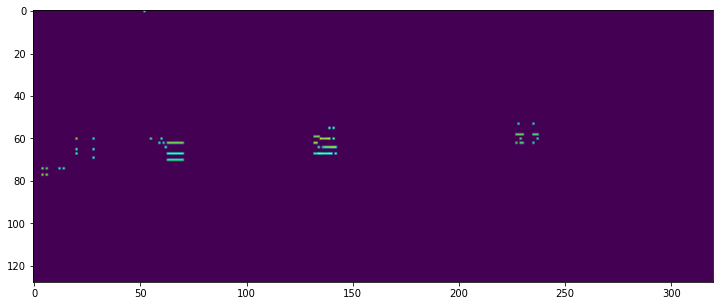

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.imshow(gen_seq.to_pianoroll(add_tempo_chord=False)[trg_inst])

In [67]:
tracks = prompt.separate_tracks()
tracks[trg_inst] = gen_seq
final_seq = MusicRepr.merge_tracks(tracks)

save_path = f'assets/EncMixDec/{file[:-4]}/'
os.makedirs(save_path, exist_ok=True)
final_seq.to_midi(save_path + f'{trg_inst}_merge.mid')
gen_seq.to_midi(save_path + f'{trg_inst}_gen.mid')
prompt.to_midi(save_path + f'{trg_inst}_prompt.mid')

ticks per beat: 192
max tick: 15360
tempo changes: 0
time sig: 1
key sig: 0
markers: 34
lyrics: False
instruments: 2